In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import re
import numpy as np
import pandas as pd
import os
import random
import string
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from tqdm import tqdm
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu

In [3]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_df=pd.read_csv('/content/drive/MyDrive/ Encoder_Decoder_English_to_Hindi/procedded_data.csv')
print(train_df.shape)
train_df.head()

(127607, 5)


,source,processed_english,processed_hindi,len_processed_english,len_processed_hindi
0,ted,politicians do not have permission to do what ...,राजनीतिज्ञों के पास जो कार्य करना चाहिए वह करन...,12,13
1,ted,i would like to tell you about one such child,मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी,10,11
2,indic2012,this percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है,10,9
3,ted,what we really mean is that they are bad at no...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते,13,11
4,indic2012,the ending portion of these vedas is called up...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है,9,8


In [6]:
max_len_eng = 18 
max_len_hindi =20 

#select only those rows which have length less than max_length
train_df=train_df[train_df['len_processed_english']<=max_len_eng] 
train_df=train_df[train_df['len_processed_hindi']<=max_len_hindi]
train_df.shape

(87563, 5)

In [7]:
train_df['encoder_input']='<start>'+' '+train_df['processed_english']+' '+'<end>'
train_df['decoder_input']='<start>'+' '+train_df['processed_hindi']+' '+'<end>'

In [8]:
#change max_length after adding <start> and <end> tokens
max_len_eng = max_len_eng+2 
max_len_hindi =max_len_hindi+2 

In [9]:
train, test = train_test_split(train_df, test_size=0.18,random_state=24)
train.shape,test.shape

((71801, 7), (15762, 7))

In [10]:
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['encoder_input'].astype(str))

vocab_size_eng = len(tknizer_eng.word_index) + 1
vocab_size_eng,max_len_eng

(37110, 20)

In [11]:
tknizer_hindi = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_hindi.fit_on_texts(train['decoder_input'].astype(str))

vocab_size_hindi = len(tknizer_hindi.word_index) + 1
vocab_size_hindi,max_len_hindi

(39411, 22)

In [12]:
X_train_e=tknizer_eng.texts_to_sequences(train['encoder_input'].astype(str))
X_train_h=tknizer_hindi.texts_to_sequences(train['decoder_input'].astype(str))
 
X_test_e=tknizer_eng.texts_to_sequences(test['encoder_input'].astype(str))
X_test_h=tknizer_hindi.texts_to_sequences(test['decoder_input'].astype(str))

In [13]:
X_train_e=pad_sequences(X_train_e,maxlen=max_len_eng,padding='post')
X_train_h=pad_sequences(X_train_h,maxlen=max_len_hindi,padding='post')
 
X_test_e=pad_sequences(X_test_e,maxlen=max_len_eng,padding='post')
X_test_h=pad_sequences(X_test_h,maxlen=max_len_hindi,padding='post')

In [14]:
print(X_train_e.shape,X_train_h.shape)
print(X_test_e.shape,X_test_h.shape)

(71801, 20) (71801, 22)
(15762, 20) (15762, 22)


In [15]:
print(X_train_e.shape)
X_train_e[0]

(71801, 20)


array([  1,   6,  12, 158,  62,  48,  34,  39,   2,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [16]:
print(X_train_h.shape)
X_train_h[0]

(71801, 22)


array([  1,  43,  29,  33, 124,   3,  25,   6,  83,  21,  49,   8,   2,
         0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [17]:
BUFFER_SIZE = X_train_e.shape[0]
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 300
units = 250

dataset = tf.data.Dataset.from_tensor_slices((X_train_e,X_train_h)) 
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [18]:
def gru(units):
    return tf.keras.layers.GRU(units, return_sequences=True,return_state=True,recurrent_activation='sigmoid',recurrent_initializer='glorot_uniform')

In [19]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [20]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [21]:
encoder = Encoder(vocab_size_eng, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_size_hindi, embedding_dim, units, BATCH_SIZE)

In [22]:
optimizer = tf.optimizers.Adam()

def loss_function(real, pred):
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) 
 
    return tf.reduce_mean(loss_)

In [23]:
checkpoint_dir = '/content/drive/MyDrive/ Attention_Mechanism_English_to_Hindi/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,encoder=encoder,decoder=decoder)

In [24]:
EPOCHS = 12
train_loss=[]
for epoch in range(EPOCHS):
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            dec_hidden = enc_hidden
            dec_input = tf.expand_dims([tknizer_hindi.word_index['<start>']] * BATCH_SIZE, 1)   
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
                 
        batch_loss = (loss / int(targ.shape[1]))
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 500 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,batch,batch_loss.numpy()))
    # saving (checkpoint) the model every epoch
    train_loss.append(total_loss / N_BATCH)
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,total_loss / N_BATCH))
    print('-'*50) 


Epoch 1 Batch 0 Loss 10.1012
Epoch 1 Batch 500 Loss 3.2646
Epoch 1 Batch 1000 Loss 3.1931
Epoch 1 Loss 3.4054
--------------------------------------------------
Epoch 2 Batch 0 Loss 3.1665
Epoch 2 Batch 500 Loss 2.9332
Epoch 2 Batch 1000 Loss 2.9723
Epoch 2 Loss 2.9207
--------------------------------------------------
Epoch 3 Batch 0 Loss 2.9555
Epoch 3 Batch 500 Loss 2.7104
Epoch 3 Batch 1000 Loss 2.7560
Epoch 3 Loss 2.6975
--------------------------------------------------
Epoch 4 Batch 0 Loss 2.7091
Epoch 4 Batch 500 Loss 2.4836
Epoch 4 Batch 1000 Loss 2.5442
Epoch 4 Loss 2.4733
--------------------------------------------------
Epoch 5 Batch 0 Loss 2.4911
Epoch 5 Batch 500 Loss 2.2536
Epoch 5 Batch 1000 Loss 2.3434
Epoch 5 Loss 2.2587
--------------------------------------------------
Epoch 6 Batch 0 Loss 2.2492
Epoch 6 Batch 500 Loss 2.0494
Epoch 6 Batch 1000 Loss 2.1498
Epoch 6 Loss 2.0513
--------------------------------------------------
Epoch 7 Batch 0 Loss 2.0167
Epoch 7 Bat

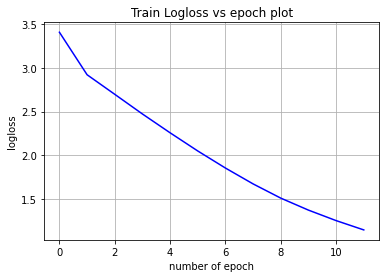

In [25]:
plt.plot(train_loss, 'b')
plt.ylabel('logloss')
plt.xlabel('number of epoch')
plt.title('Train Logloss vs epoch plot')
plt.grid()
plt.show()

In [26]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [27]:
def evaluate(inputs, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = ''  
    for i in inputs[0]:
        if i == 0:
            break
        sentence = sentence + tknizer_eng.index_word[i] + ' '
    sentence = sentence   #English sentence
    inputs = tf.convert_to_tensor(inputs)
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tknizer_hindi.word_index['<start>']], 0)
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        if predicted_id==0:
            return result, sentence, attention_plot
        elif tknizer_hindi.index_word[predicted_id] == '<end>' :
            return result, sentence, attention_plot
        else:
            result += tknizer_hindi.index_word[predicted_id] + ' '  #predicted hindi sentence
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

In [28]:
# Function to predict and plot randomly selected test point
def predict_and_plot_attention():
    actual_sent = ''
    k = np.random.randint(len(X_train_e))
    random_input = X_train_e[k]
    random_output = X_train_h[k]
    random_input = np.expand_dims(random_input,0)
    result, sentence, attention_plot = evaluate(random_input, encoder, decoder, tknizer_eng, tknizer_hindi, max_len_eng, max_len_hindi)
    print('English sentence          : ',sentence)
    for i in random_output:
        if i == 0:
            break
        actual_sent = actual_sent + tknizer_hindi.index_word[i] + ' '
    print('Hindi sentence           : ',actual_sent)
    print('Predicted Hindi sentence : ',result)
    attention_plot = attention_plot[:len(result.split(' '))-1, 1:len(sentence.split(' '))-2]
    sentence, result = sentence.split(' '), result.split(' ')
    sentence = sentence[1:-2]
    result = result[:-1]
    fig = go.Figure(data=go.Heatmap(z=attention_plot,x=sentence,y=result,hoverongaps = False))
    fig.show()

## Sample Translations with Attention Plots

In [32]:
predict_and_plot_attention()

English sentence          :  <start> which she could use <end> 
Hindi sentence           :  <start> जो वो उपयोग कर सके <end> 
Predicted Hindi sentence :  जो वो भी होना चाहिए 


In [42]:
predict_and_plot_attention()

English sentence          :  <start> applause <end> 
Hindi sentence           :  <start> अभिवादन <end> 
Predicted Hindi sentence :  अभिवादन 


In [46]:
predict_and_plot_attention()

English sentence          :  <start> so i left them with it <end> 
Hindi sentence           :  <start> तो मैंने उन्हें कंप्यूटर के साथ छोड़ दिया <end> 
Predicted Hindi sentence :  तो मैं उन्हें इसे वापस आया 


In [34]:
# Function to predict the sentence
def predict_random_sentence(k,X_e,X_h):
    actual_sent = ''
    input_ = X_e[k]
    output_ = X_h[k]
    input_ = np.expand_dims(input_,0)
    result, sentence, attention_plot = evaluate(input_, encoder, decoder, tknizer_eng, tknizer_hindi, max_len_eng, max_len_hindi)
    for i in output_:
        if i == 0:
            break
        actual_sent = actual_sent + tknizer_hindi.index_word[i] + ' '
    return sentence,actual_sent,result

# Train set Examples

In [35]:
r=random.sample(range(len(X_train_e)),10)
for i in r:
  random_input = X_train_e[i]
  s,a,p=predict_random_sentence(i,X_train_e,X_train_h)
  print('English sentence         : ',s)
  print('Hindi sentence           : ',a)
  print('Predicted Hindi sentence : ',p)
  print('-'*100)

English sentence         :  <start> or in his increasingly ambitious installation work <end> 
Hindi sentence           :  <start> या अपनी तेजी से महत्वाकांक्षी स्थापना के काम में <end> 
Predicted Hindi sentence :  या फिर वर्षा ऋतु में वृद्धि हुई 
----------------------------------------------------------------------------------------------------
English sentence         :  <start> it is capital is jaipur <end> 
Hindi sentence           :  <start> यहाँ की राजधानी जयपुर है <end> 
Predicted Hindi sentence :  यह महानगर जयपुर की राजधानी है 
----------------------------------------------------------------------------------------------------
English sentence         :  <start> see this also <end> 
Hindi sentence           :  <start> यह भी देखें <end> 
Predicted Hindi sentence :  यह भी देखें 
----------------------------------------------------------------------------------------------------
English sentence         :  <start> premchand has written about three hundred stories many essays and a

## Test set Examples

In [36]:
r=random.sample(range(len(X_test_e)),10)
for i in r:
  random_input = X_test_e[i]
  s,a,p=predict_random_sentence(i,X_test_e,X_test_h)
  print('English sentence         : ',s)
  print('Hindi sentence           : ',a)
  print('Predicted Hindi sentence : ',p)
  print('-'*100)
r=random.sample(range(len(X_test_e)),10)

English sentence         :  <start> for years i have watched people teach <end> 
Hindi sentence           :  <start> कई सालो तक मैने लोगों को पढाते देखा है <end> 
Predicted Hindi sentence :  सालों से पहले मुझे लोग उसे याद रखते हैं 
----------------------------------------------------------------------------------------------------
English sentence         :  <start> i think it is true that we will face a dilemma in this respect <end> 
Hindi sentence           :  <start> मैं समझता हूं हमें इस संबंध में दुविधा का सामना करना पडेगा <end> 
Predicted Hindi sentence :  मुझे लगता है कि मुझे लगता है कि हम मनुषयों के बारे में यह एक ईंट तक की तरह से 
----------------------------------------------------------------------------------------------------
English sentence         :  <start> sitting at a keyboard <end> 
Hindi sentence           :  <start> करते हुए <end> 
Predicted Hindi sentence :  एक कार्टूनिस्ट के लिए 
-----------------------------------------------------------------------------------

In [37]:
# Function to compute BLEU score
def compute_BLEU_score(X_e,X_h,n):
    bleu_score=0
    r=random.sample(range(len(X_e)),n)
    for i in tqdm(r):
        s,a,p=predict_random_sentence(i,X_e,X_h)
        p=p.replace('<end>','')
        p=p.replace('<start>','').split()
        a=a.replace('<end>','')
        a=a.replace('<start>','').split()
        score = sentence_bleu([a],p)
        bleu_score+=score
    return(np.round(bleu_score/len(r),4))

## BLEU score on Train set

In [38]:
#bleu score of 10000 randomly selected sentences
train_bleu_score=compute_BLEU_score(X_train_e,X_train_h,10000)

100%|██████████| 10000/10000 [30:55<00:00,  5.39it/s]


In [39]:
print('BLEU score of Train set : ',train_bleu_score)

BLEU score of Train set :  0.4848


# BLEU score on Test set

In [40]:
#bleu score of 10000 randomly selected sentences
test_bleu_score=compute_BLEU_score(X_test_e,X_test_h,10000)

100%|██████████| 10000/10000 [30:24<00:00,  5.48it/s]


In [41]:
print('BLEU score of Test set : ',test_bleu_score)

BLEU score of Test set :  0.4329


# Refrences

https://www.tensorflow.org/text/tutorials/nmt_with_attention

https://towardsdatascience.com/intuitive-understanding-of-attention-mechanism-in-deep-learning-6c9482aecf4f